In [222]:
import pandas as pd
import numpy as np
import cufflinks as cf
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


from boruta import BorutaPy

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split, 
                                    GridSearchCV, 
                                    TimeSeriesSplit, 
                                    cross_val_score,
                                    RandomizedSearchCV
                                    )
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, fbeta_score, make_scorer,
                            roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.compose import TransformedTargetRegressor


from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [30]:
def parkinson(price_data, window=30, day_count=252):
    log_hl = np.log(price_data['High']/price_data['Low'])
    sum_log_hl_sq = log_hl.rolling(window).apply(lambda x: np.sum(np.square(x)), raw=True)    
    volatility = sqrt(day_count) * np.sqrt((1 / (4 * np.log(2))) * (1 / window) * sum_log_hl_sq)
    return volatility

def rodgers_satchell(price_data, window=30, day_count=252):
    log_hc = np.log(price_data['High'] / price_data['Close'])
    log_ho = np.log(price_data['High'] / price_data['Open'])
    log_lc = np.log(price_data['Low'] / price_data['Close'])
    log_lo = np.log(price_data['Low'] / price_data['Open'])
    sum_prod = (log_hc * log_ho + log_lc * log_lo).rolling(window).sum()
    volatility = sqrt(day_count) * np.sqrt((1 / (window)) * sum_prod)
    return volatility

def garman_klass(price_data, window=30, day_count=252):
    log_hl = np.log(price_data['High']/price_data['Low'])
    log_ctc = np.log(price_data['Close']/price_data['Close'].shift(1))
    sum_log_hl_sq = log_hl.rolling(window).apply(lambda x: np.sum(np.square(x)), raw=True)
    sum_log_ctc_sq = log_ctc.rolling(window).apply(lambda x: np.sum(np.square(x)), raw=True)
    volatility = sqrt(day_count) * np.sqrt((1 / (window)) * (0.5 * sum_log_hl_sq - (2 * np.log(2) - 1) *
                                                            sum_log_ctc_sq))
    return volatility

def yang_zhang(price_data, window=30, day_count=252):
    log_olc = np.log(price_data['Open']/price_data['Close'].shift(1))
    log_clo = np.log(price_data['Close']/price_data['Open'].shift(1))
    sigma_o_sq = (1 / (window - 1)) * log_olc.rolling(window).apply(lambda x: np.sum(np.square(x)), raw=True)
    sigma_c_sq = (1 / (window - 1)) * log_clo.rolling(window).apply(lambda x: np.sum(np.square(x)), raw=True)
    sigma_rs_sq = (window / (day_count * (window - 1))) * \
    rodgers_satchell(price_data, window=window, day_count=day_count) ** 2
    k = 0.34 / (1 + (window + 1) / (window - 1))
    volatility = sqrt(day_count) * np.sqrt(sigma_o_sq  + k * sigma_c_sq + (1 - k) * sigma_rs_sq)
    return volatility

def rolling_z(price_data, window=30, standardize=True):
    if standardize:
        z_scores = (price_data - price_data.rolling(window, min_periods=window).mean()) \
            / price_data.rolling(window, min_periods=window).std()
    else:
        z_scores = price_data / price_data.rolling(window, min_periods=window).std()
    return z_scores

In [31]:
ccies = ['EUR', 'JPY', 'GBP', 'CAD', 'AUD', 'NZD', 'CHF']
strong = ['EUR', 'GBP', 'AUD', 'NZD']

df_spot = pd.read_csv('FXSpot.csv', index_col=0, parse_dates=True).sort_index().ffill()
df_vol = pd.read_csv('FXVol.csv', index_col=0, parse_dates=True).sort_index().ffill()
df_indices = pd.read_csv('Index.csv', index_col=0, parse_dates=True).sort_index().ffill()

In [32]:
df_spot.info()
df_vol.info()
df_indices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44100 entries, 2000-01-03 to 2024-02-23
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   security  44100 non-null  object 
 1   PX_OPEN   44100 non-null  float64
 2   PX_LAST   44100 non-null  float64
 3   PX_HIGH   44100 non-null  float64
 4   PX_LOW    44100 non-null  float64
dtypes: float64(4), object(1)
memory usage: 2.0+ MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6300 entries, 2000-01-03 to 2024-02-23
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   EURUSD CMP Curncy       6300 non-null   float64
 1   EURSN CMP Curncy        6300 non-null   float64
 2   EURUSDV1M CMP Curncy    6300 non-null   float64
 3   EURUSD25B1M CMP Curncy  5323 non-null   float64
 4   EURUSD25R1M CMP Curncy  5322 non-null   float64
 5   USDJPY CMP Curncy       6300 non-null   float64
 

In [33]:
df_returns = pd.DataFrame(index=df_spot.index.unique(), columns=ccies)
for c in ccies:
    df = df_spot[df_spot['security'] == c + ' CMP Curncy']['PX_LAST']
    df_returns[c] = df.pct_change()
idx = pd.date_range(end=df_vol.index[-1], start = df_vol.index[0], freq='BM')
realised_vol = pd.DataFrame(index=idx, columns=ccies)
implied_vol = pd.DataFrame(index=idx, columns=ccies)
for i, d in enumerate(idx[:-1]):
    for ccy in ccies:
        realised_vol[ccy].loc[d] = np.sqrt(260) * (df_returns.loc[d:idx[i+1], ccy]).std()
        if ccy in strong:
            implied_vol[ccy].loc[d] = df_vol.loc[d, ccy + 'USDV1M CMP Curncy']
        else:
            implied_vol[ccy].loc[d] = df_vol.loc[d, 'USD' + ccy + 'V1M CMP Curncy']

In [34]:
y = (implied_vol - 100 * realised_vol).dropna()

In [37]:
raw_features = pd.DataFrame(index=df_vol.index)

raw_features = raw_features.merge(df_indices.add_suffix('_all'), on='date')

window = 22
day_count = 260

vol = np.sqrt(day_count * (df_returns ** 2).ewm(alpha=0.03, min_periods=window).mean())
raw_features = raw_features.merge(vol.add_prefix('realised_ewm_'), on='date')
vol = np.sqrt(day_count * (df_returns ** 2).rolling(window=window, min_periods=window).mean())
raw_features = raw_features.merge(vol.add_prefix('realised_ctc_'), on='date')

for ccy in ccies:
    if ccy in strong:
        atm = df_vol[ccy + 'USDV1M CMP Curncy']
        rr = df_vol[ccy + 'USD25R1M CMP Curncy']
        bf = df_vol[ccy + 'USD25B1M CMP Curncy']
    else:
        atm = df_vol['USD' + ccy + 'V1M CMP Curncy']
        rr = df_vol['USD' + ccy + '25R1M CMP Curncy']
        bf = df_vol['USD' + ccy + '25B1M CMP Curncy']
    raw_features['implied_atm_'+ccy] = atm
    raw_features['implied_skew_'+ccy] = (rr) / atm
    raw_features['implied_kurt_'+ccy] = (bf) / atm
    ohlc = df_spot[df_spot['security'] == ccy + ' CMP Curncy'][['PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST']]
    ohlc.columns = ['Open', 'High', 'Low', 'Close']
    for e,p in zip(['par', 'gk', 'rs', 'yz'], [parkinson, garman_klass, rodgers_satchell, yang_zhang]):
        raw_features['realised_'+e+'_'+ccy] = p(ohlc, window=window, day_count=day_count)
    raw_features['spot_range_'+ccy] = (ohlc['High'] - ohlc['Low']).rolling(window=window, min_periods=window).mean()
    

In [41]:
window = 260
pct_features = raw_features.rolling(window=window, min_periods=window).rank(pct=True).add_prefix('pct_')

In [42]:
atm_col = ['implied_atm_'+ccy for ccy in ccies]
spreads = pd.DataFrame(index=raw_features.index, columns=raw_features.filter(regex='realised').columns)
for e in ['ctc', 'ewm', 'par', 'gk', 'rs', 'yz']:
    realised_col = ['realised_'+e+'_'+ccy for ccy in ccies]
    spreads[realised_col] = np.log(raw_features[atm_col].values/(100*raw_features[realised_col]).values)
spreads = spreads.add_prefix('spread_')

In [48]:
pct_features.filter(regex='pct_implied_atm').dropna()

,pct_implied_atm_EUR,pct_implied_atm_JPY,pct_implied_atm_GBP,pct_implied_atm_CAD,pct_implied_atm_AUD,pct_implied_atm_NZD,pct_implied_atm_CHF
date,,,,,,,
2001-01-01,0.653846,0.313462,0.636538,0.805769,0.713462,0.625000,0.726923
2001-01-02,0.880769,0.290385,0.734615,0.994231,0.792308,0.607692,0.725000
2001-01-03,0.844231,0.263462,0.763462,0.992308,0.819231,0.623077,0.819231
2001-01-04,0.821154,0.284615,0.776923,0.990385,0.828846,0.690385,0.803846
2001-01-05,0.825000,0.438462,0.748077,0.988462,0.884615,0.661538,0.742308
...,...,...,...,...,...,...,...
2024-02-16,0.003846,0.011538,0.003846,0.007692,0.003846,0.003846,0.069231
2024-02-20,0.015385,0.053846,0.011538,0.009615,0.007692,0.003846,0.109615
2024-02-21,0.023077,0.088462,0.015385,0.021154,0.015385,0.011538,0.259615


In [304]:
X = z_features.dropna()
idx = (X.index).intersection(y.index)
X, y = X.loc[idx], y.loc[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [173]:
X = pct_features.filter(regex='pct_implied_atm').merge(spreads, on='date').dropna()
idx = (X.index).intersection(y.index)
X, y = X.loc[idx], y.loc[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [242]:
def data_flat(X, selected_features, selected_currencies, add_common=False):
    X_flat = pd.DataFrame()
    for f in selected_features:
        col = np.array([])
        for c in selected_currencies:
            col = np.concatenate((col, X[f+'_'+c].values), axis=None)
        X_flat[f] = col
    if add_common:
        common_features = list(X.filter(regex='_all').columns)
        for f in common_features:
            col = np.array([])
            for c in selected_currencies:
                col = np.concatenate((col, X[f].values), axis=None)
            X_flat[f] = col
    return X_flat

def data_flat_(X, selected_features, selected_currencies, add_common=False):
    X_flat = pd.DataFrame()
    i = 0
    for d in X.index:
        for c in selected_currencies:
            for f in selected_features:
                X_flat.loc[i, f] = X.loc[d, f+'_'+c]
            i += 1
    if add_common:
        common_features = list(X.filter(regex='_all').columns)
        i = 0
        for d in X.index:
            for f in common_features:
                for c in selected_currencies:
                    X_flat.loc[i, f] = X.loc[d, f]
                i += 1
    return X_flat.to_numpy()

def target_flat_(y, selected_currencies):
    y_flat = y[selected_currencies].to_numpy().flatten(order='C')
    return y_flat

In [172]:
selected_features = ['pct_implied_atm', 'spread_realised_ewm']
selected_currencies = ccies
X_train_flat = data_flat(X_train, selected_features, selected_currencies)
X_test_flat = data_flat(X_test, selected_features, selected_currencies)
y_train_flat = pd.Series(y_train[selected_currencies].values.flatten(order='C'))
y_test_flat = pd.Series(y_test[selected_currencies].values.flatten(order='C'))

KeyError: 'spread_realised_ewm_EUR'

In [80]:
threshold = 0.5
labels_train = (y_train_flat > threshold).astype(int)
labels_test = (y_test_flat > threshold).astype(int)

              precision    recall  f1-score   support

           0       0.52      0.41      0.46       754
           1       0.53      0.63      0.58       786

    accuracy                           0.52      1540
   macro avg       0.52      0.52      0.52      1540
weighted avg       0.52      0.52      0.52      1540



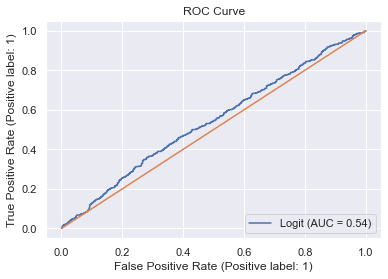

In [136]:
clf = LogisticRegression()
clf.fit(X_train_flat, labels_train)
print(classification_report(labels_train, clf.predict(X_train_flat)))

disp_roc = RocCurveDisplay.from_estimator(
        clf, 
        X_train_flat, 
        labels_train,
        name='Logit')
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1])
plt.show()

In [137]:
print(sqrt(12)*(clf.predict(X_train_flat) * y_train_flat).mean()/(clf.predict(X_train_flat) * y_train_flat).std())
print(sqrt(12)*(y_train_flat).mean()/(y_train_flat).std())

0.31407539235236237
0.31108572056647654


In [194]:
pct_spreads = spreads.rolling(window=window, min_periods=window).rank(pct=True).add_prefix('pct_')
X = pct_features.filter(regex='pct_implied_atm').merge(pct_spreads.filter(regex='pct_spread_realised_ewm'), on='date').dropna()
idx = (X.index).intersection(y.index)
X, y = X.loc[idx], y.loc[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [207]:
pct_spreads = spreads.rolling(window=window, min_periods=window).rank(pct=True).add_prefix('pct_')
X = pct_features.filter(regex='pct_implied_atm').merge(pct_spreads.filter(regex='pct_spread_realised_ewm'), on='date').dropna()
idx = (X.index).intersection(y.index)
X, y = X.loc[idx], y.loc[idx]
selected_features = ['pct_implied_atm', 'pct_spread_realised_ewm']
selected_currencies = ccies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_flat = data_flat_(X_train, selected_features, selected_currencies)
X_test_flat = data_flat_(X_test, selected_features, selected_currencies)
y_train_flat = pd.Series(y_train[selected_currencies].values.flatten(order='C'))
y_test_flat = pd.Series(y_test[selected_currencies].values.flatten(order='C'))
threshold = 0.5
labels_train = (y_train_flat > threshold).astype(int)
labels_test = (y_test_flat > threshold).astype(int)

In [202]:
threshold = 0.5
labels_train = (y_train_flat > threshold).astype(int)
labels_test = (y_test_flat > threshold).astype(int)

In [245]:
data_flat_(X_train, selected_features, selected_currencies)

array([[0.55961538, 0.13076923],
       [0.52307692, 0.49615385],
       [0.49038462, 0.43846154],
       ...,
       [0.29230769, 0.95384615],
       [0.63846154, 0.94230769],
       [0.06923077, 0.86538462]])

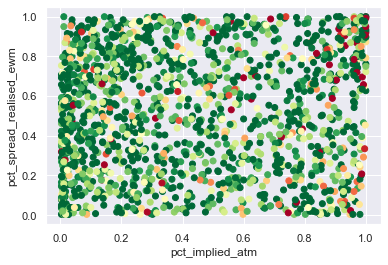

In [109]:
plt.scatter(X_train_flat.iloc[:,0], X_train_flat.iloc[:,1], c=y_train_flat, cmap='RdYlGn', vmin=-5, vmax=1)
plt.xlabel(X_train_flat.columns[0])
plt.ylabel(X_train_flat.columns[1])
plt.show()

In [258]:
pipeline_cv = Pipeline([
    ('svm', SVC())  # SVM classifier
])
param_grid_svm = [ {'svm__C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100, 125, 150, 175, 200],
                    'svm__kernel':['linear']},
                  {'svm__C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100, 125, 150, 175, 200],
                   'svm__kernel':['rbf'],
                   'svm__gamma':["scale", "auto", 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}]
grid_search = GridSearchCV(pipeline_cv, param_grid_svm, n_jobs=-1, cv=tscv, scoring='accuracy')
grid_search.fit(X_train_flat, labels_train)
grid_search.best_params_

{'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

In [260]:
pipeline = Pipeline([  # Preprocessing step: Standardization
    ('svm', SVC(C=100, gamma='scale', kernel='rbf', probability=True))  # SVM classifier
])

pipeline.fit(X_train_flat, labels_train)

print ("Train Set ROC-AUC Score: %.3f" % roc_auc_score(labels_train, pipeline.predict(X_train_flat)))
print(classification_report(labels_train, pipeline.predict(X_train_flat)))
scores = cross_val_score(pipeline, X_train_flat, labels_train, n_jobs=-1,
                         scoring='precision', cv=tscv)
print("Cross Validation ROC-AUC score average: %.3f" % scores.mean())
print("Cross Validation ROC-AUC score average: %.3f" % scores.std())

Train Set ROC-AUC Score: 0.571
              precision    recall  f1-score   support

           0       0.58      0.48      0.52       754
           1       0.57      0.67      0.61       786

    accuracy                           0.57      1540
   macro avg       0.57      0.57      0.57      1540
weighted avg       0.57      0.57      0.57      1540

Cross Validation ROC-AUC score average: 0.507
Cross Validation ROC-AUC score average: 0.060


In [261]:
train_pnl = pd.DataFrame(index=X_train.index, columns=selected_currencies)
proba = pd.DataFrame(index=X_train.index, columns=selected_currencies)
for ccy in selected_currencies:
    c = [f + '_' + ccy for f in selected_features]
    train_pnl[ccy] = pipeline.predict(X_train[c].values) * y_train[ccy]
    proba[ccy] = pipeline.predict_proba(X_train[c].values)[:,1]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

In [262]:
pnl = train_pnl.sum(axis=1)
print(sqrt(12)*pnl.mean()/pnl.std())
print(sqrt(12)*y_train.sum(axis=1).mean()/y_train.sum(axis=1).std())
pd.concat([pnl, y_train.sum(axis=1)], axis=1).cumsum().iplot()

1.2177257491513864
0.46297425474917314


In [263]:
ls_position = (proba.rank(axis=1) >= (len(proba.columns) - 1)).astype(int) - (proba.rank(axis=1) <= 2).astype(int)
ls_pnl = (ls_position * y_train).sum(axis=1)
print(sqrt(12)*ls_pnl.mean()/ls_pnl.std())
ls_pnl.cumsum().iplot()

0.7336048546743607


In [265]:
print ("Test Set ROC-AUC Score: %.3f" % roc_auc_score(labels_test, pipeline.predict(X_test_flat)))
print(classification_report(labels_test, pipeline.predict(X_test_flat)))

Test Set ROC-AUC Score: 0.522
              precision    recall  f1-score   support

           0       0.59      0.46      0.52       217
           1       0.46      0.58      0.51       168

    accuracy                           0.51       385
   macro avg       0.52      0.52      0.51       385
weighted avg       0.53      0.51      0.51       385



In [264]:
test_pnl = pd.DataFrame(index=X_test.index, columns=selected_currencies)
proba = pd.DataFrame(index=X_test.index, columns=selected_currencies)
for ccy in selected_currencies:
    c = [f + '_' + ccy for f in selected_features]
    test_pnl[ccy] = pipeline.predict(X_test[c].values) * y_test[ccy]
    proba[ccy] = pipeline.predict_proba(X_test[c].values)[:,1]
pnl = test_pnl.sum(axis=1)
print(sqrt(12)*pnl.mean()/pnl.std())
print(sqrt(12)*y_test.sum(axis=1).mean()/y_test.sum(axis=1).std())
pd.concat([pnl, y_test.sum(axis=1)], axis=1).cumsum().iplot()
ls_position = (proba.rank(axis=1) >= (len(proba.columns) - 1)).astype(int) - (proba.rank(axis=1) <= 2).astype(int)
ls_pnl = (ls_position * y_test).sum(axis=1)
print(sqrt(12)*ls_pnl.mean()/ls_pnl.std())
ls_pnl.cumsum().iplot()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

0.7242794010833719
-0.03015303936240962


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



0.27473271022237805


In [243]:
data_flat_transformer = FunctionTransformer(data_flat_, kw_args={'selected_features':selected_features, 'selected_currencies':selected_currencies})
target_flat_transformer = FunctionTransformer(target_flat_, kw_args={'selected_currencies':selected_currencies})
pipeline_cv = Pipeline([
    ('preprocess', data_flat_transformer),
    ('svm', SVC())  # SVM classifier
])
model = TransformedTargetRegressor(regressor=pipeline_cv, transformer=target_flat_transformer)
param_grid_svm = [ {'regressor__svm__C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100, 125, 150, 175, 200],
                    'regressor__svm__kernel':['linear']},
                  {'regressor__svm__C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100, 125, 150, 175, 200],
                   'regressor__svm__kernel':['rbf'],
                   'regressor__svm__gamma':["scale", "auto", 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}]
grid_search = GridSearchCV(model, param_grid_svm, n_jobs=-1, cv=tscv, scoring='f1_macro', error_score='raise')
grid_search.fit(X_train, (y_train>0.5).astype(int))
grid_search.best_params_

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [233]:
grid_search.get_params()

{'cv': TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
 'error_score': nan,
 'estimator__check_inverse': True,
 'estimator__func': None,
 'estimator__inverse_func': None,
 'estimator__regressor__memory': None,
 'estimator__regressor__steps': [('preprocess',
   FunctionTransformer(func=<function data_flat_ at 0x7fe98b83f8b0>,
                       kw_args={'selected_currencies': ['EUR', 'JPY', 'GBP', 'CAD',
                                                        'AUD', 'NZD', 'CHF'],
                                'selected_features': ['pct_implied_atm',
                                                      'pct_spread_realised_ewm']})),
  ('svm', SVC())],
 'estimator__regressor__verbose': False,
 'estimator__regressor__preprocess': FunctionTransformer(func=<function data_flat_ at 0x7fe98b83f8b0>,
                     kw_args={'selected_currencies': ['EUR', 'JPY', 'GBP', 'CAD',
                                                      'AUD', 'NZD', 'CHF'],
       

In [108]:
print(sqrt(12)*(pipeline.predict(X_train_flat) * y_train_flat).mean()/(pipeline.predict(X_train_flat) * y_train_flat).std())
print(sqrt(12)*(y_train_flat).mean()/(y_train_flat).std())
print((pipeline.predict(X_train_flat) * y_train_flat).mean(), y_train_flat.mean())

0.6968862109634592
0.31108572056647654
0.3526540300714039 0.27793777548720205


In [91]:
selected_features = ['pct_implied_atm', 'pct_spread_realised_ewm']
selected_currencies = ccies
X_train_flat = data_flat(X_train, selected_features, selected_currencies)
X_test_flat = data_flat(X_test, selected_features, selected_currencies)
y_train_flat = pd.Series(y_train[selected_currencies].values.flatten(order='F'))
y_test_flat = pd.Series(y_test[selected_currencies].values.flatten(order='F'))

In [21]:
selected_features = [s[:-4] for s in list(X.filter(regex='EUR').columns)]
selected_currencies = ccies
X_train_flat = data_flat(X_train, selected_features, selected_currencies, add_common=True)
X_test_flat = data_flat(X_test, selected_features, selected_currencies, add_common=True)
y_train_flat = pd.Series(y_train[selected_currencies].values.flatten(order='F'))
y_test_flat = pd.Series(y_test[selected_currencies].values.flatten(order='F'))
threshold = 0.5
labels_train = (y_train_flat > threshold).astype(int)
labels_test = (y_test_flat > threshold).astype(int)

In [22]:
fs = SelectKBest(score_func=f_classif)
fit = fs.fit(X_train_flat,labels_train)
features_p = pd.Series(index=X_train_flat.columns, data=fit.pvalues_)
#X_train.drop(features_p[features_p > 0.05].index, axis=1, inplace=True)
features_p.sort_values().head(15)

spread_realised_ctc    0.011467
spread_realised_gk     0.064245
spread_realised_par    0.066192
spread_realised_rs     0.081599
spread_realised_yz     0.134437
z_implied_atm          0.159194
spread_realised_ewm    0.194169
z_implied_kurt         0.213771
z_spot_range           0.262517
z_realised_yz          0.262537
z_realised_gk          0.298420
z_realised_rs          0.299059
z_realised_par         0.306514
z_realised_ewm         0.364563
z_CVIX1I Index_all     0.379059
dtype: float64

In [15]:
features_to_drop = []
features_corr = X_train_flat.corr()
for i in features_corr[(features_corr > 0.9) & (features_corr < 1)].\
unstack().dropna().sort_values(ascending=False).index:
    if features_p[i[0]] > features_p[i[1]]:
        features_to_drop.append(i[0])
    else:
        features_to_drop.append(i[1])

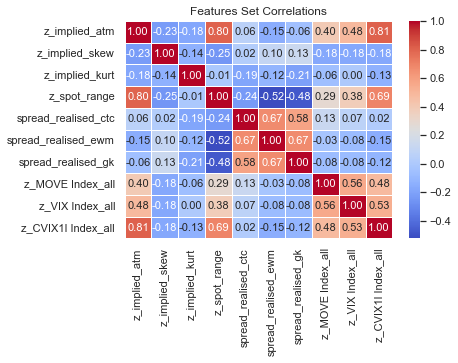

In [16]:
X_train_flat.drop(set(features_to_drop), axis=1, inplace=True)
sns.set(rc={'figure.figsize': (20, 10)})

sns.heatmap(X_train_flat.corr(), 
            annot=True,  
            annot_kws={"size": 11}, 
            fmt=".2f", 
            linewidth=.5, 
            cmap="coolwarm", 
            cbar=True);

plt.title('Features Set Correlations');

In [23]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)
param_grid = {"n_estimators":[10, 100, 500],
              "max_depth":[3, 4, 5, 6, 7, 8]}

fs_model = GridSearchCV(RandomForestClassifier(random_state=42), 
                        param_grid, n_jobs=-1, cv=tscv, scoring='roc_auc')
fs_model.fit(X_train_flat, labels_train)
fs_model.best_params_

{'max_depth': 6, 'n_estimators': 500}

Index(['z_realised_ctc', 'z_realised_ewm', 'z_implied_atm', 'z_implied_skew',
       'z_implied_kurt', 'z_realised_par', 'z_realised_gk', 'z_realised_rs',
       'z_realised_yz', 'z_spot_range', 'spread_realised_ctc',
       'spread_realised_ewm', 'spread_realised_par', 'spread_realised_gk',
       'spread_realised_rs', 'spread_realised_yz', 'z_MOVE Index_all',
       'z_VIX Index_all', 'z_CVIX1I Index_all'],
      dtype='object')

In [24]:
fs_model = RandomForestClassifier(max_depth=6, n_estimators=500, random_state=42)
fs_model.fit(X_train_flat, labels_train)

boruta = BorutaPy(estimator=fs_model, n_estimators = 'auto', random_state=42)
boruta.fit(np.array(X_train_flat), np.array(labels_train))
strong_support = X_train_flat.columns[boruta.support_].to_list()
weak_support = X_train_flat.columns[boruta.support_weak_].to_list()
print('Boruta Strong features:', strong_support)
print('Boruta Weak features:', weak_support)

Boruta Strong features: ['spread_realised_gk', 'z_MOVE Index_all', 'z_VIX Index_all', 'z_CVIX1I Index_all']
Boruta Weak features: []


In [27]:
selected_features = strong_support + weak_support
X_train_flat, X_test_flat = X_train_flat[selected_features], X_test_flat[selected_features]

              precision    recall  f1-score   support

           0       0.56      0.51      0.53       394
           1       0.56      0.60      0.58       404

    accuracy                           0.56       798
   macro avg       0.56      0.56      0.56       798
weighted avg       0.56      0.56      0.56       798



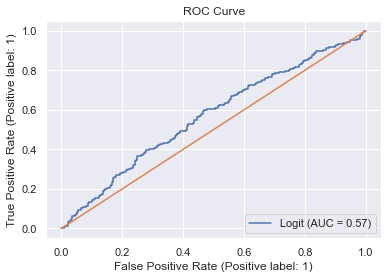

In [28]:
clf = LogisticRegression()
clf.fit(X_train_flat, labels_train)
print(classification_report(labels_train, clf.predict(X_train_flat)))

disp_roc = RocCurveDisplay.from_estimator(
        clf, 
        X_train_flat, 
        labels_train,
        name='Logit')
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1])
plt.show()

In [267]:
param_grid = {"n_estimators":[10, 100, 500],
              "max_depth":[3, 4, 5, 6]}

fs_model = GridSearchCV(RandomForestClassifier(random_state=42), 
                        param_grid, n_jobs=-1, cv=tscv, scoring='roc_auc')
fs_model.fit(X_train_flat, labels_train)
fs_model.best_params_

{'max_depth': 6, 'n_estimators': 500}

              precision    recall  f1-score   support

           0       0.67      0.73      0.70       394
           1       0.71      0.66      0.68       404

    accuracy                           0.69       798
   macro avg       0.69      0.69      0.69       798
weighted avg       0.69      0.69      0.69       798



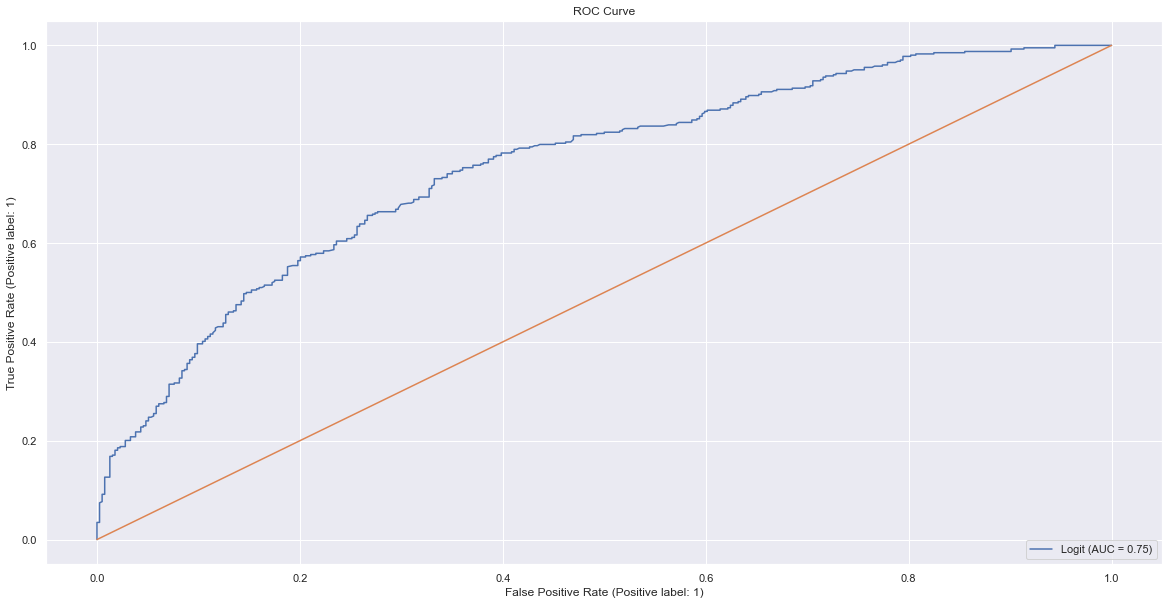

Cross Validation ROC-AUC average: 0.577
Cross Validation ROC-AUC std: 0.046


In [276]:
clf = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=42)
clf.fit(X_train_flat, labels_train)
print(classification_report(labels_train, clf.predict(X_train_flat)))

disp_roc = RocCurveDisplay.from_estimator(
        clf, 
        X_train_flat, 
        labels_train,
        name='Logit')
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1])
plt.show()

scores = cross_val_score(clf, X_train_flat, labels_train, n_jobs=-1,
                         scoring='precision', cv=tscv)
print("Cross Validation ROC-AUC average: %.3f" % scores.mean())
print("Cross Validation ROC-AUC std: %.3f" % scores.std())

<Axes: xlabel='pct_implied_atm', ylabel='pct_spread_realised_ewm'>

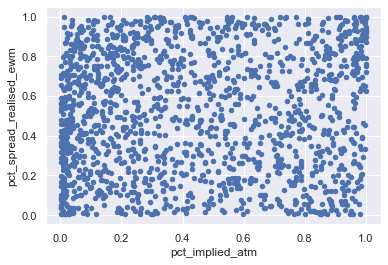

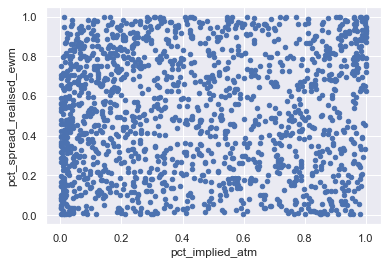

In [164]:
data_flat_(X_train, selected_features, selected_currencies, add_common=True).plot(kind='scatter', x='pct_implied_atm', y='pct_spread_realised_ewm')
data_flat(X_train, selected_features, selected_currencies, add_common=True).plot(kind='scatter', x='pct_implied_atm', y='pct_spread_realised_ewm')

In [171]:
pd.Series(y_train[selected_currencies].values.flatten(order='C'))

0      -0.263303
1       0.740484
2       2.368389
3       0.494784
4       2.631824
          ...   
1535   -0.079395
1536     0.77273
1537      2.3093
1538    2.894235
1539    0.130325
Length: 1540, dtype: object

In [170]:
y_train[selected_currencies].head(10)

,EUR,JPY,GBP,CAD,AUD,NZD,CHF
2001-01-31,-0.263303,0.740484,2.368389,0.494784,2.631824,3.282652,1.193744
2001-02-28,1.40949,-1.088062,0.921389,-0.680576,-0.931396,1.280752,1.020532
2001-03-30,-0.246623,-1.214863,0.596449,1.338963,-2.732554,0.99162,-1.245965
2001-04-30,3.855189,-0.005763,0.858298,0.620677,3.799657,2.068022,5.299309
2001-05-31,-0.248843,1.866288,-2.579603,0.686264,0.233053,1.681527,-0.680308
2001-06-29,-0.176724,0.163493,0.545882,2.108489,2.067225,5.735306,-1.754272
2001-07-31,2.646559,-0.062667,1.089214,0.996091,-0.136272,4.286731,2.087228
2001-08-31,-4.019205,-1.314906,0.87823,2.510569,-2.237156,-2.965492,-7.194581
2001-09-28,2.239975,4.600378,-0.672305,1.776522,2.095831,5.823876,1.731624
2001-10-31,2.279842,2.054055,1.019049,1.200356,4.592097,4.006413,1.383847
